# Исследование отмененных заказов

<font size="4"><b>О проекте:</b></font>

В приложении компании в момент, когда клиент нажимает на кнопку "Заказать" в приложении, система матчинга подыскивает наиболее релевантых курьеров и предлагаем им заказ. Необходимо провести исследование заказов клиентов и данных о назначении курьеров по этим заказам, ответить на вопросы заказчика и дать рекомендации исходя из наблюдаемых закономерностей. 

***Цель:*** *исследовать некоторые метрики неудачных заказов.*

***Задачи:***
1. *Провести предобработку данных*
2. *Провести исследовательский анализ данных*
3. *Ответить на вопросы заказчика*
4. *Дать рекомендации*

<font size="4"><b>Описание данных:</b></font>

Есть два датасета: 
- `data_orders` - содержит выборку данных по заказам клиентов;
- `data_offers` - содержит пары номер заказа - ID оффера, который был предложен курьеру по данному заказу.

Датасет `data_orders` содержит следующие колонки:
* `order_datetime` -  время заказа
* `order_gk` - номер заказа
* `order_status_key` - статус (4 - отменен клиентом, 9 - отменен системой (reject))
* `is_courier_assigned_key` - был ли назначен курьер
* `cancellations_time_in_seconds` - сколько секунд прошло до отмены

## Общее

### Загрузка данных

In [129]:
import math as mth
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [130]:
# загрузка данных
orders_raw = pd.read_csv('data_orders.csv')
offers = pd.read_csv('data_offers.csv')

### Определение функций

#### Список функций

- `df_info()` - для вывода общей информации о данных;
- `check_duples()` - для проверки на дубликаты;
- `add_labels()` - для добавления числовых значений в графиках-рейтингах;
- `pass_value_barh()` - для подсчета пропусков в столбцах;
- `percentils()` - для расчета интересующих перцентилей;
- `plot_pie()` - для отрисовки круговых графиков;
- `waiting_in_time()` - для отрисовки графика времени ожидания до отмены заказа в течение дня;
- `ratio_per_category()` - для построения графика доли какой-либо категории в зависимости от времени.

#### `df_info()`

In [131]:
# введём функцию, позволяющую вывести общую информацию о данных

def df_info(df, figsize=(10, 5)):
    
    """Вывод общей информации о данных

    df - датасет,
    figsize - размер гистограмм
    """
    
    print('Вид данных:')
    display(df.head())
    
    print()
    print('Общая информация о данных:')
    print()
    df.info()
   
    
    # Построим гистограммы для тех числовых полей, которые не являются идентификаторами, если такие есть в датасете
    if len(df.select_dtypes(include=['int64', 'float64']).columns) != 0:
        print()
        print('Распределения числовых величин в данных:')
        df.hist(figsize=figsize, color='SteelBlue', grid=False, bins=60);


#### `check_duples()`

In [132]:
def check_duples(df, cols):
    # проверим датасет на явные дубликаты

    if len(df[df.duplicated()]) != 0:
        print('Количество дубликатов:',
              len(df[df.duplicated()])
             )
    else:
        print('Явные дубликаты не найдены')
        
    for col in cols:

        if len(df[df[col].duplicated()]) == 0:
            print(f'Дубликаты по {col} не найдены')
        else:
            print(f'Количество дубликатов {col}:',
                  len(df[df[col].duplicated()]),
                  '({:.2%})'.format(
                      len(df[df[col].duplicated()]) / \
                      len(df)
                  )
                 )

#### `add_labels()`

In [133]:
# добавление числовых значений на графиках-рейтингах (типа barh)
def add_labels(x, y, score=1, inter=0, percent=False, color='white'):
    
    """Функция добавляет подписи значений для графиков типа barh.
    
    Принимаемые параметры:
    х - названия категорий
    у - список значений параметра для каждой категории
    score - число для корректировки положения надписи относительно длины столбца: score умножается на значение параметра,
            например, если длина столбца - 20, a score=1/2, то подпись к этому столбцу будет расположена посередине столбца
    inter - число для корректировки положения надписи относительно длины столбца: добавляет к положению, определенному
            с помощью score сдвиг по оси Ох
    percent - когда True: добавляет значение доли данной категории относительно всех изображенных на графике,
              например, если всего 2 категории cat1 = 700, cat2=300, то подпишет, что доля cat1 = 70%, а доля cat2=30%
    color - цвет подписи значения столбца, не влияет на цвет подписи доли катигории (цвет доли всегда чёрный)
    """
    # для каждой категории 
    for i in range(len(x)):
        plt.text(
            y[i] * score + inter, # положение по оси Ох
            i,                    # положение по оси Оу 
            y[i],                 # отображаемое значение (значение столбца)
            ha = 'center', size=12, va='center', color=color, fontweight='bold' # форматирование выводимого текста
        )
        
        # выводим, если нужны доли категории относительно всех выведенных на графике
        if percent:
            plt.text(y[i] + y.max()/10, i, f'{round(y[i] / y.sum() * 100, 2)}%', 
                     ha = 'center', size=14, va='center', color='black')

#### `pass_value_barh()`

In [134]:
# посмотрим долю пропущенных значений в столбцах
def pass_value_barh(df):
    
    """Функция выводит долю пропущенных значений по столбцам.
    
    Принимаемые параметры:
    df - исследуемый датасет
    """
    
    # выделим пространство под график
    fig = plt.figure(figsize=(7,2))
    fig.suptitle('Доля пропусков в столбцах' + "\n", fontsize=14)
    fig.add_subplot(111)
    
    # группируем информацию
    df = (
        (df.isna().mean()*100)              # даёт долю пропущенных значений от всего датасета
        .to_frame()                         # чтобы работать как с DataFrame
        .rename(columns = {0:'ratio'})
        .query('ratio > 0')                 # рассмотрим только столбцы с пропущенными значениями
        .sort_values(by = 'ratio', ascending = True)
    )
    
    df['ratio'] = round(df['ratio'], 2)
    
    # построим график
    (
        plt
        .barh( 
            y=df.index,
            width=df['ratio'],
            color='SteelBlue',
            height=0.5
        )
    )
    
    # редактируем подписи
    plt.xlabel('Доля в столбце, %', fontsize=10)
    plt.yticks(fontsize=10)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    
    add_labels(df.index, df['ratio'], score=1/2, inter=1, color='black')

#### `percentils()`

In [135]:
# функция для расчета интересующих перцентилей
def percentils(data, col, perc=[90, 95, 99]):
    
    percs = np.percentile(data[col], perc)
    
    for i in range(len(perc)):
        print(f"{perc[i]}-й перцентиль: {percs[i]:.2f}")

#### `plot_pie()`

In [136]:
def plot_pie(df, col, title, labels=None):
    
    if labels == None:
        (
            df
            .groupby(col)
            .agg('count')['order_gk']
            .sort_values()
            .plot(
                kind='pie', 
                colors = sns.color_palette('Set2'),
                ylabel='',
                autopct='%1.0f%%',
                textprops={'fontsize':10},
                title=title
            )
        )
    else:
        (
            df
            .groupby(col)
            .agg('count')['order_gk']
            .sort_values()
            .plot(
                kind='pie', 
                colors = sns.color_palette('Set2'),
                ylabel='',
                autopct='%1.0f%%',
                textprops={'fontsize':10},
                labels=labels,
                title=title
            )
        )

#### `waiting_in_time()`

In [137]:
def waiting_in_time(data, ax, label=False):
    
    df = (
        data[['cancellations_time_in_seconds', 'order_hour']]
        .groupby('order_hour')
        .agg({'cancellations_time_in_seconds' : 'median'})
    )
    
    df.plot(ax=ax, legend=False, marker='o', label=label)
    
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel('Время заказа')
    plt.ylabel('Медианное время до отмены заказа')
    
    return ax

#### `ratio_per_category()`

In [138]:
def ratio_per_category(df, task, cat, title, task_0, task_1, l=None, title_part='', figsize = (13, 5)):
    
    # пространство для графика
    fig, ax = plt.subplots(figsize = figsize)
    
    # порядок на диаграмме и агрегация данных
    r = range(len(df[cat].unique()))
    df_grouped = df.groupby([cat, task])['order_gk'].agg('count')
    raw = {task_1 : df_grouped[:, 1], task_0 : df_grouped[:, 0]}
    df = pd.DataFrame(raw)
    
    # группы для диаграммы с подсчетом доли
    totals = [i+j for i, j in zip(df[task_1], df[task_0])]
    churn_uids = [i/j*100 for i, j in zip(df[task_1], totals)]
    with_us = [i/j*100 for i, j in zip(df[task_0], totals)]
    
    # толщина колонок и названия групп
    barWidth = 0.85
    if l == None:
        names = df.index
    else:
        names = l
    
    # первые колонки для оставшихся
    plt.bar(r, with_us, color=sns.color_palette('Set2')[0], edgecolor='white', width=barWidth, label=task_0)
    
    #for i in range(len(with_us)):
        #plt.text(i, with_us[i] // 2, f'{round(with_us[i])}%', ha='center', va='center', size=14, fontweight='bold')
        
    # вторые колонки для ушедших
    plt.bar(r, churn_uids, bottom=with_us, color=sns.color_palette('Set2')[1], edgecolor='white', width=barWidth, label=task_1)
    
    #for i in range(len(churn_uids)):
        #plt.text(i, with_us[i] + churn_uids[i] // 2, f'{round(churn_uids[i])}%', ha='center', va='center', size=14, fontweight='bold')
        
     # подписи на оси х
    plt.xticks(r, names)

    # добавление легенды
    plt.legend(loc='upper left', bbox_to_anchor=(1,1), ncol=1, fontsize=14)
 
    # подписи и вывод графика
    plt.title(title + title_part + '\n', fontsize=16)
    plt.ylabel('Доля от всех заказов группы, %', fontsize=12)
    plt.xlabel(cat, fontsize=12)
    plt.yticks(fontsize=14)
    plt.xticks(fontsize=12)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(0.5)
    ax.spines['left'].set_linewidth(0.5)
    ax.set_ylim(0, 100)
    plt.tight_layout()
    plt.show()

### Общая информация о датасете

Вид данных:


,order_datetime,order_gk,order_status_key,is_courier_assigned_key,cancellations_time_in_seconds
0,2020-07-22 18:08:07,3000583041974,4,1,198.0
1,2020-07-22 20:57:32,3000583116437,4,0,128.0
2,2020-07-22 12:07:50,3000582891479,4,1,46.0
3,2020-07-22 13:50:20,3000582941169,4,1,62.0
4,2020-07-22 21:24:45,3000583140877,9,0,NaN



Общая информация о данных:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10716 entries, 0 to 10715
Data columns (total 5 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_datetime                 10716 non-null  object 
 1   order_gk                       10716 non-null  int64  
 2   order_status_key               10716 non-null  int64  
 3   is_courier_assigned_key        10716 non-null  int64  
 4   cancellations_time_in_seconds  7307 non-null   float64
dtypes: float64(1), int64(3), object(1)
memory usage: 418.7+ KB

Распределения числовых величин в данных:


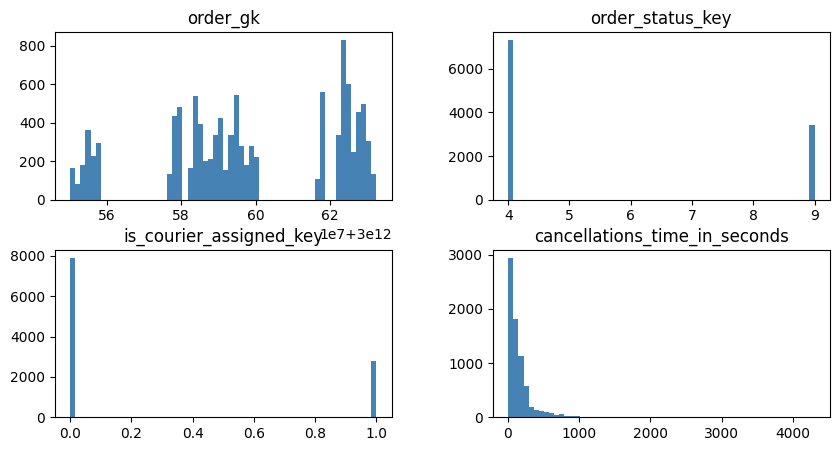

In [139]:
df_info(orders_raw)

Каждая строка датасета `orders` содержит информацию об отдельном отмененном заказе: время заказа, номер заказа, причина отмены (код 4 или 9), флаг о назначении курьера, "время жизни" заказа до отмены.

Есть информация о 10716 заказах, пропуски есть только в данных о времени жизни заказа. В выборке больше заказов, для которых курьер не был назначен, а в разбивке по коду отмены больше тех, которые были отменены клиентом. Распределение времени жизни имеет пуассоновский вид, что ожидаемо. 

Также можно заметить, что на гистограмме с номерами заказов присутствуют провалы. Причина этого, вероятно в том, что номера, которые отсутствуют в датасете, относятся к заказам, которые не были отменены.

In [140]:
# изучим offers
offers.head()

,order_gk,offer_id
0,3000579625629,300050936206
1,3000627306450,300052064651
2,3000632920686,300052408812
3,3000632771725,300052393030
4,3000583467642,300051001196


In [141]:
offers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 334363 entries, 0 to 334362
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype
---  ------    --------------   -----
 0   order_gk  334363 non-null  int64
 1   offer_id  334363 non-null  int64
dtypes: int64(2)
memory usage: 5.1 MB


Размер датасета `offers` на порядок больше датасета `orders`. Это может быть следствием того, что предложения по одному и тому же заказу отправляются сразу нескольким курьерам.

## Предобработка данных

### Поиск дубликатов

Проверим на дубликаты датасет `orders`.

In [142]:
# создадим копию исходного датасета для его преобразований
orders = orders_raw.copy()

In [143]:
# проверим датасет на явные дубликаты
# а также на дубликаты по номерам заказов
check_duples(orders, ['order_gk'])

Явные дубликаты не найдены
Дубликаты по order_gk не найдены


Проверим на дубликаты датасет `offers`.

In [144]:
# проверим датасет на явные дубликаты
# а также на дубликаты по предложениям курьерам 
# (дубликаты по заказам искать не будем, т.к. на один заказ может быть выслано несколько предложений курьерам)
check_duples(offers, ['offer_id'])

Явные дубликаты не найдены
Дубликаты по offer_id не найдены


В ходе проверки не было найдено дубликатов.

### Работа с пропусками

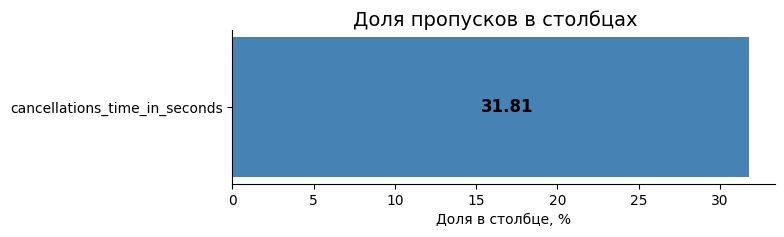

In [145]:
pass_value_barh(orders)

В датасете orders присутствуют пропуски в столбце о времени жизни заказа до отмены `cancellations_time_in_seconds`. Доля пропусков составляет 32%, поэтому удалить эти данные без исследования нельзя.

Посмотрим, насколько сильно отличаются другие признаки заказа в зависимости от наличия пропуска в `cancellations_time_in_seconds`.

In [146]:
# создадим новый столбец-метку, в котором:
# 0 - в `cancellations_time_in_seconds` нет пропуска
# 1 - в `cancellations_time_in_seconds` пропуск

orders['null_flag'] = 0
orders.loc[orders['cancellations_time_in_seconds'].isna(), 'null_flag'] = 1

In [147]:
# добавим изменненный столбец order_status_key, в котором заменим код 4 на 0, а код 9 на 1
orders['order_status_flag'] = 0
orders.loc[orders['order_status_key'] == 9, 'order_status_flag'] = 1

In [148]:
# построим сводную таблицу с агреггированными значениями признаков заказа
# в зависимости от наличия/отсутствия пропуска в `cancellations_time_in_seconds`

# столбец с датой рассмотрим отдельно следующим шагом

(
    orders
    .groupby('null_flag')
    .agg({
        'cancellations_time_in_seconds' : 'median',
        'order_status_flag' : 'mean',  # покажет долю заказов, которые были отменены системой
        'is_courier_assigned_key' : 'mean'  # покажет долю заказов, которым был назначен курьер
    })
    .rename(index={
        0 : 'time_exist',
        1 : 'null_value_in_time'
    })
)

,cancellations_time_in_seconds,order_status_flag,is_courier_assigned_key
null_flag,,,
time_exist,98.0,0,0.38470
null_value_in_time,NaN,1,0.00088


Из таблице выше видно, что **все заказы**, в которых не известно время жизни, **были отменены системой**, поэтому эти пропуски не являются абсолютно случайными. Кроме того, доля курьеров, назначенных по таким заказам, составляет сотые процента.

Таким образом, удалять или как-либо изменять эти пропуски нельзя, так как они напрямую связаны с кодом отмены заказа. Однако, после проверки столбца `cancellations_time_in_seconds` на аномалии, пропуски будут заменены на значение-метку.

Возможно, что для таких заказов есть пропуски во времени жизни по той причине, что заказ по каким-либо причинам (плохое интернет-соединение, ошибка оплаты и т.д.) отменяется практически сразу после своего формирования. Другой причиной может являться некоторый временный сбой, возникший в самой системе.

In [149]:
# посмотрим, сколько дней представлено в датасете
print(pd.to_datetime(orders['order_datetime']).dt.date.unique())

[datetime.date(2020, 7, 22)]


В датасете представлены заказы за один день. В таком случае, посмотрим долю отмененных системой заказов в течение дня за каждый час.

In [150]:
# создадим столбец, где укажем, к какому часу относится заказ 
# (округляется к ближайшему часу)
orders['order_hour'] = pd.to_datetime(orders['order_datetime']).dt.round('H')

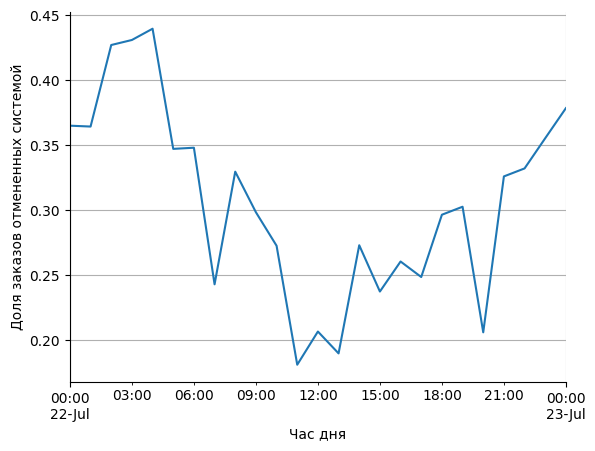

In [151]:
(
    orders
    .groupby('order_hour')
    .agg({
        'null_flag' : 'mean'
    })
    .plot(legend = False)
)

plt.xlabel('Час дня', fontsize=10)
plt.ylabel('Доля заказов отмененных системой', fontsize=10)
plt.yticks(fontsize=10)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.grid(visible=True)

В графике не наблюдается аномальных провалов, следовательно, пропуски в столбце `cancellations_time_in_seconds` не связаны с временем заказа. 

Вероятно, существует некоторая суточная периодичность, связанная с отменами заказов, однако это утверждение невозможно проверить на имеющихся данных.

### Поиск аномалий

#### `order_datetime`

In [152]:
print('В датасете представлена информация об одном дне:', 
      pd.to_datetime(orders['order_datetime']).dt.date.unique()[0],
     ' - аномалий в столбце о времени нет.')

В датасете представлена информация об одном дне: 2020-07-22  - аномалий в столбце о времени нет.


#### `cancellations_time_in_seconds`

In [153]:
orders['cancellations_time_in_seconds'].describe()

count    7307.000000
mean      157.892021
std       213.366963
min         3.000000
25%        45.000000
50%        98.000000
75%       187.500000
max      4303.000000
Name: cancellations_time_in_seconds, dtype: float64

Медианное время времени жизни заказа составляет полторы минуты. Однако в данных есть заказы, которые отменялись спустя час ожидания. Отрицательных значений нет. Время ожидания, равное 0 также отсутствует. Тогда пропущенные значения в этом столбце можем заменить на "-1".

Посмотрим, есть ли зависимость времени ожидания заказа от времени суток заказа.

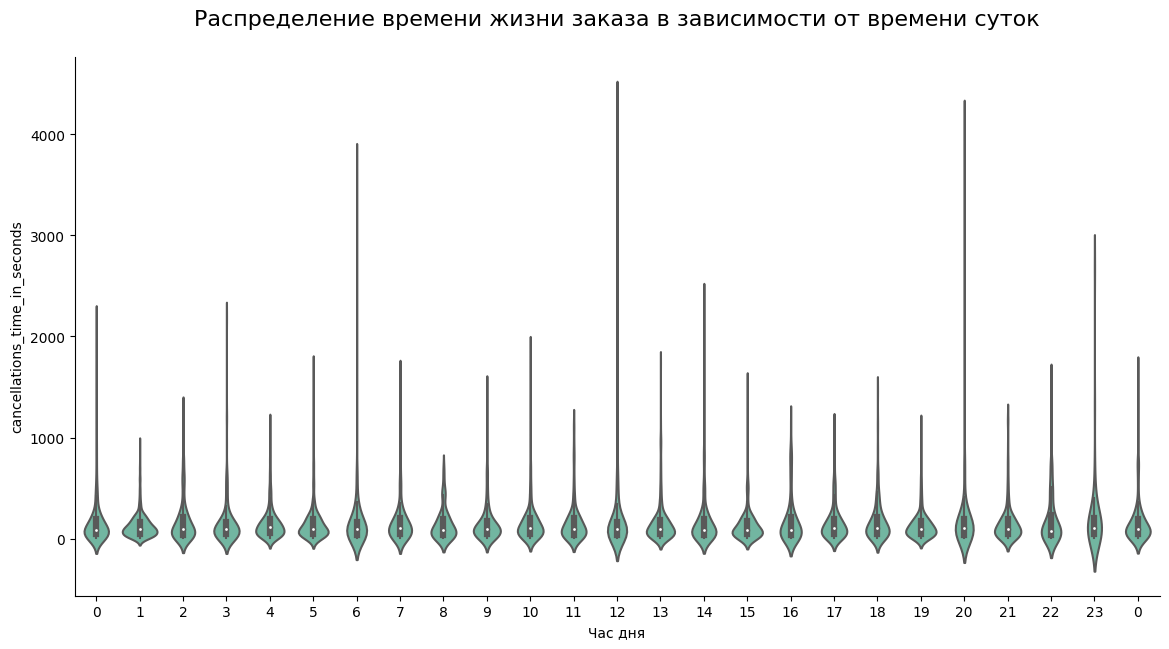

In [154]:
fig, ax = plt.subplots(figsize=(14, 7))
sns.violinplot(x=orders['order_hour'], y=orders['cancellations_time_in_seconds'], 
               ax=ax, color = sns.color_palette('Set2')[0])

plt.xlabel('')
plt.title('Распределение времени жизни заказа в зависимости от времени суток' + '\n', fontsize=16);
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
# подписи на оси х
ax.set_xticklabels(pd.DatetimeIndex(orders['order_hour'].sort_values().unique()).hour)
plt.xlabel('Час дня', fontsize=10);

Самые долгие времена жизни заказов выпадают около полуночи, а также в 6 утра, 12 дня и 20 вечера. Чтобы говорить о некоторой периодичности отмены заказа именно в эти часы, необходимо располагать данными за несколько недель. В данном случае ничего дополнительно сказать нельзя.

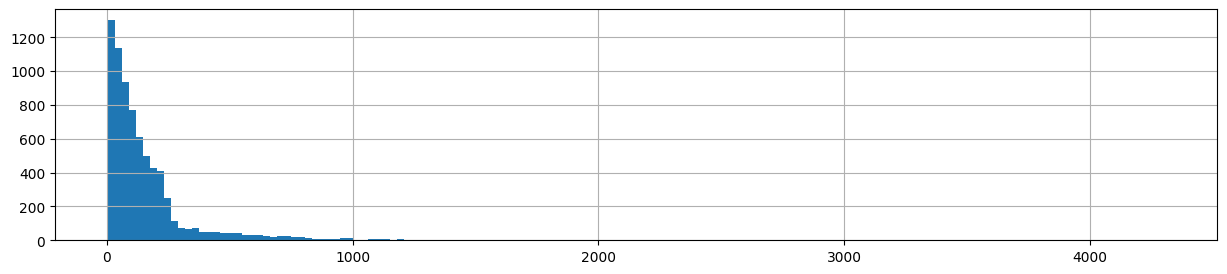

In [155]:
orders['cancellations_time_in_seconds'].hist(bins=150, figsize=(15, 3));

In [156]:
# расчитаем 90-й, 95-й и 99-й перцентили
percentils(orders[~(orders['cancellations_time_in_seconds'].isna())], 'cancellations_time_in_seconds')

90-й перцентиль: 339.00
95-й перцентиль: 544.40
99-й перцентиль: 996.94


Как видим, менее 5% заказов имеют время жизни более 545 с (около 9 мин). В таком случае, оставим для дальнейшего исследования заказы, чьё время жизни составляет не более 10 мин (600 c).

In [157]:
orders = orders[(orders['cancellations_time_in_seconds'] <= 600) | (orders['cancellations_time_in_seconds'].isna())]

In [158]:
print('Доля удаленных данных:', 
      f'{((len(orders_raw) - len(orders)) / len(orders)):.2%}')

Доля удаленных данных: 2.90%


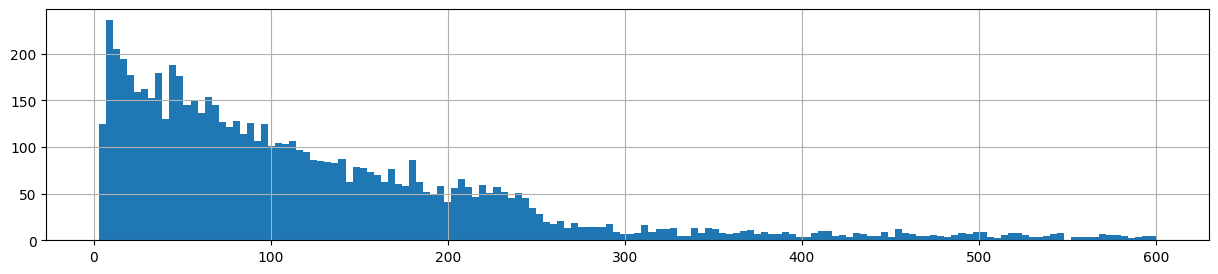

In [159]:
# посмотрим на распределение оставшихся данных
orders['cancellations_time_in_seconds'].hist(bins=150, figsize=(15, 3));

In [160]:
# заменим пустые значения в столбце на "-1"
orders.loc[orders['cancellations_time_in_seconds'].isna(), 'cancellations_time_in_seconds'] = -1

In [161]:
# проверим успешность замены
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10414 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10414 non-null  object        
 1   order_gk                       10414 non-null  int64         
 2   order_status_key               10414 non-null  int64         
 3   is_courier_assigned_key        10414 non-null  int64         
 4   cancellations_time_in_seconds  10414 non-null  float64       
 5   null_flag                      10414 non-null  int64         
 6   order_status_flag              10414 non-null  int64         
 7   order_hour                     10414 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(5), object(1)
memory usage: 732.2+ KB


### Преобразование типов данных

In [162]:
# преобразование данных о времени
orders['order_datetime'] = pd.to_datetime(orders['order_datetime'])

# преобразование столбца о времени жизни в int
orders['cancellations_time_in_seconds'] = orders['cancellations_time_in_seconds'].astype('int')

In [163]:
# проверим успешность замены
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10414 entries, 0 to 10715
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_datetime                 10414 non-null  datetime64[ns]
 1   order_gk                       10414 non-null  int64         
 2   order_status_key               10414 non-null  int64         
 3   is_courier_assigned_key        10414 non-null  int64         
 4   cancellations_time_in_seconds  10414 non-null  int32         
 5   null_flag                      10414 non-null  int64         
 6   order_status_flag              10414 non-null  int64         
 7   order_hour                     10414 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int32(1), int64(5)
memory usage: 691.6 KB


### Согласованность датасетов

В датасете `orders` есть метка о назначении курьера. В датасете `offers` присутствуют предложения курьерам по заказам. Посмотрим, по всем ли заказам из `orders` отправлялись предложения курьерам.

In [168]:
unique_orders = orders['order_gk'].unique()
orders_with_offers = offers['order_gk'].unique()

In [169]:
unoffered_orders = []
for order in unique_orders:
    if order not in orders_with_offers:
        unoffered_orders.append(order)
print('Количество заказов, по которым курьерам не поступало предложений:', len(unoffered_orders))

extra_orders = []
for order in orders_with_offers:
    if order not in unique_orders:
        extra_orders.append(order)
print('Количество заказов c предложениями в offers, по которым нет информации в orders:', len(extra_orders))

Количество заказов, по которым курьерам не поступало предложений: 3031
Количество заказов c предложениями в offers, по которым нет информации в orders: 90584


В датасете `offers` присутствует информация о заказах, которых нет в таблице `orders`. Удалим эти строки из `offers`.

In [170]:
offers = offers[~(offers['order_gk'].isin(extra_orders))]

In [171]:
orders_with_offers = offers['order_gk'].unique()
extra_orders = []

for order in orders_with_offers:
    if order not in unique_orders:
        extra_orders.append(order)
print('Количество заказов c предложениями в offers, по которым нет информации в orders:', len(extra_orders))

Количество заказов c предложениями в offers, по которым нет информации в orders: 0


Помимо этого, есть 3031 заказ, по которым не поступало никаких предложений курьерам. Посмотрим, совпадают ли эти заказы с теми, которые в `orders` отмечены как заказы без курьера.

In [172]:
orders_without_courier = orders[orders['is_courier_assigned_key'] == 0]['order_gk'].unique()

In [173]:
unmatched_orders = []
for order in unoffered_orders:
    if order not in orders_without_courier:
        unmatched_orders.append(order)
print('Количество несовпадений:', len(unmatched_orders))    

Количество несовпадений: 412


В датасете `orders` присутствуют заказы, где в признаке о курьере указано, что курьер назначен, в то время как информации о предложениях курьерам по этим курьерам в offers нет. Этому существует 2 объяснения: либо в программе есть какая-либо ошибка, либо в выданном датасете `offers` есть не вся информация о заказах от 22-27-2020.

In [174]:
# добавим в датасет метку о заказе с несовпадением данных
orders['is_unmatched_order'] = 0
orders.loc[orders['order_gk'].isin(unmatched_orders), 'is_unmatched_order'] = 1

In [175]:
# посмотрим на особенности заказов с несовпадениями
(
    orders
    .groupby('is_unmatched_order')
    .agg({
        'cancellations_time_in_seconds' : 'median',
        'order_status_flag' : 'mean',  # покажет долю заказов, которые были отменены системой
        'is_courier_assigned_key' : 'mean'  # покажет долю заказов, которым был назначен курьер
    })
    .rename(index={
        0 : 'normal',
        1 : 'unmatched_orders'
    })
)

,cancellations_time_in_seconds,order_status_flag,is_courier_assigned_key
is_unmatched_order,,,
normal,39,0.340732,0.213357
unmatched_orders,180,0.002427,1.000000


Для заказов с несовпадениями наблюдается следующее:
- медианное время ожидание таких заказов значительно выше,
- в основном эти заказы были отменены клиентами.

Можно сделать предположение, что всё-таки существовала какая-то ошибка в системе. Возможно, что программа считала, что курьер назначен, в то время как на самом деле никаких предложений курьерам не отправлялось, клиент ожидал решения своей проблемы, недожидался, отменял заказ.

### Итог предобработки

1. ***Дубликаты в датасетах отсутствуют.***
2. *Пропуски есть только в столбце о времени жизни заказа.*
3. ***Пропуски о времени жизни есть только у тех заказов, которые были отменены системой.*** *Возможно, что для таких заказов есть пропуски во времени жизни по той причине, что заказ (например, из-за плохого интернет-соединения, ошибки оплаты и т.д.) отменяется практически сразу после своего формирования.*
4. *Пропуски во времени жизни были заменены специальным значением **"-1"**.*
5. *Обнаружены* ***аномально высокие значения*** *в столбце о* ***времени жизни заказа:*** *некоторые заказы отменяются спустя час ожидания.*
6. *Самые долгие времена жизни заказов выпадают в полночь, а также в 5, 7 утра и 13 дня. Чтобы говорить о некоторой периодичности отмены заказа именно в эти часы, необходимо располагать данными за несколько недель. В данном случае ничего дополнительно сказать нельзя.*
7. *Для дальнейшнего исследования* ***были оставлены только те заказы, чьё время ожидания укладывается в 10 мин.*** *Доля потерянных данных составила **менее 3%**.*
8. *Были заменены типы данных.*
9. *Был добавлен **столбец с количеством минут ожидания заказа до его отмены**. Значение получено путём округления времени вверх (53 секунды считаются 2-мя минутами).*
10. *В датасете `offers` обнаружены записи о заказах, информация о которых отсутствует в `orders`. Такие записи были удалены.*
11. *Обнаружены **заказы с несовпадением информации о курьере в `orders` и `offers`:** в первом датасете отмечено, что курьер для заказа назначен, в то время как в `offers` нет информации о предложениях по этому заказу курьерам. Этому может быть 2 причины: либо `offers` не обладает полной информацией о заказах в течение исследуемого дня, либо есть ошибка в системе. Исходя из наблюдаемых зависимостей, вторая причина может быть верной:* ***возможно, что программа считала, что курьер назначен, в то время как на самом деле никаких предложений курьерам не отправлялось, клиент ожидал решения своей проблемы, не дожидался, отменял заказ.***

## Исследовательский анализ данных

### Общие характеристики

In [176]:
# выведем основную информацию
print(f'В датасете есть информация о {len(orders)} заказах/заказе.')
print(f'Все заказы представлены за одну дату: {(pd.to_datetime(orders["order_datetime"]).dt.date[0])} ')

В датасете есть информация о 10414 заказах/заказе.
Все заказы представлены за одну дату: 2020-07-22 


#### Доля заказов по коду отмены

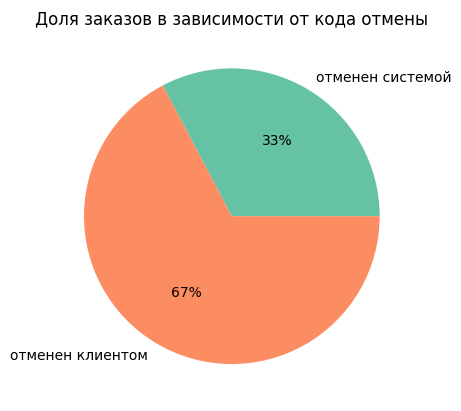

In [177]:
plot_pie(orders, 'order_status_key', 
         'Доля заказов в зависимости от кода отмены', labels=['отменен системой', 'отменен клиентом'])

Большая часть заказов (67%) отменена клиентом. Треть заказов отменена системой. Кроме того, для этой трети заказов отсутствует информация о времени жизни заказа, возможно, что эти заказы были отменены в первую секунду формирования.

#### Доля заказов в зависимости от назначения курьера

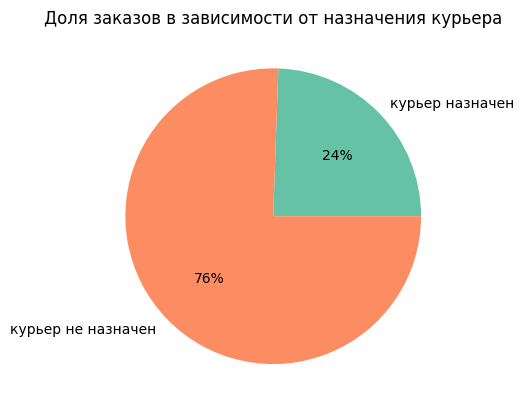

In [178]:
plot_pie(orders, 'is_courier_assigned_key', 
         'Доля заказов в зависимости от назначения курьера', labels=['курьер назначен', 'курьер не назначен'])

Большинство заказов в датасете (76%) были отменены ещё до назначения курьера.

#### Доля заказов с несовпадениями

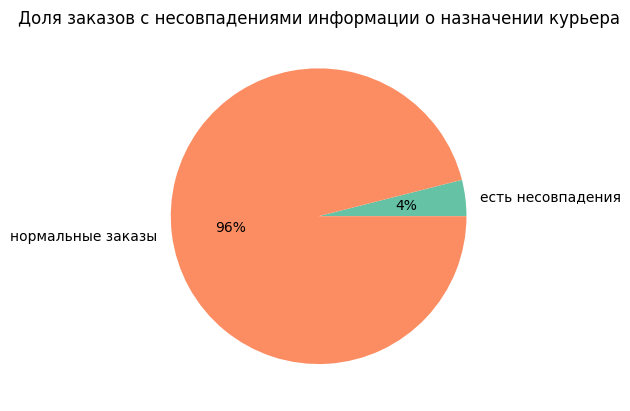

In [179]:
plot_pie(orders, 'is_unmatched_order', 
         'Доля заказов с несовпадениями информации о назначении курьера', labels=['есть несовпадения', 'нормальные заказы'])

У 4% заказов присутствуют несовпадения с датасетом `offers` касательно информации о назначении курьера. Как было отмечено в пункте 2.6, эти несовпадения могут быть вызваны ошибкой в программе: для заказов с несовпадениями наблюдается повышенное время ожидания до отмены и увличенная доля заказов, отмененных клиентами самостоятельно. Возможно, что программа "считала", что курьер назначен, в то время как на самом деле никаких предложений курьерам не отправлялось, клиент ожидал решения своей проблемы, недожидался, отменял заказ.

#### Время с наибольшим числом заказов

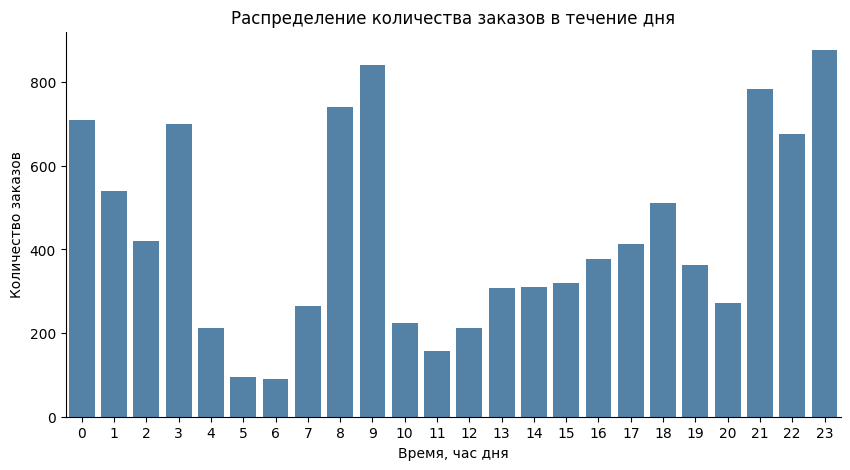

In [180]:
fig, ax = plt.subplots( figsize=(10, 5))
sns.despine(left=False, ax=ax)

sns.countplot(data=orders, x=orders['order_hour'].dt.hour, color='steelblue', ax=ax)
plt.title('Распределение количества заказов в течение дня')
plt.ylabel('Количество заказов')
plt.xlabel('Время, час дня');

По графику можно отметить, что в этот день самые активные на заказы часы были утром (8-9 ч утра) и вечером (21-24 ч). Меньше всего заказов ранним утром (4-6 утра), а также около 11ч.

In [181]:
print('Максимальное количество заказов в течение часа составляет',
     (
         orders[['order_hour', 'order_gk']]
         .groupby('order_hour').agg({'order_gk' : 'count'}).sort_values(by='order_gk', ascending=False).values[0][0]
     ),
     'заказа/заказов и приходится на',
    (
         orders[['order_hour', 'order_gk']]
         .groupby('order_hour').agg({'order_gk' : 'count'}).sort_values(by='order_gk', ascending=False).index[0].hour
     ),
      'час/а.'
     )

Максимальное количество заказов в течение часа составляет 877 заказа/заказов и приходится на 23 час/а.


#### Среднее время для отмены

In [182]:
# найдём медианную оценку времени жизни заказа (берём медиану, т.к. распределение не нормальное)
print('Среднее время для отмены по всему датасету составляет',
     int(orders['cancellations_time_in_seconds'].median()), 'с.')

Среднее время для отмены по всему датасету составляет 44 с.


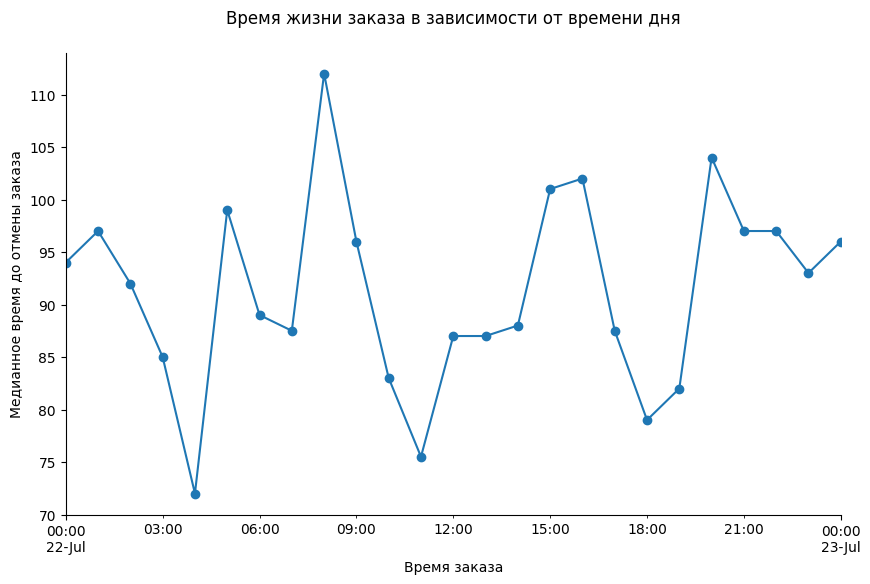

In [183]:
# посмотрим распределение медианного значения времени жизни заказа 
# по часам
fig, ax = plt.subplots(figsize=(10, 6))
waiting_in_time(orders[orders['cancellations_time_in_seconds'] != -1], ax)
plt.title('Время жизни заказа в зависимости от времени дня' + '\n', fontsize=12);

На графике в целом не наблюдаются сильно выделяющиеся часы. В среднем меньше всего время ожидания клиентом до отмены было в 4ч утра, дольше всего ждали в 8 утра.

### Вопросы заказчика

#### Для всех ли заказов нашлись офферы курьерам?

In [184]:
print('В ходе предобработки данных было обнаружено, что не по всем заказам были отправлены предложения клиентам:')
print(len(unoffered_orders), 'заказов без предложений, из них', len(unmatched_orders), 'заказа/ов с несовпадениями.')

В ходе предобработки данных было обнаружено, что не по всем заказам были отправлены предложения клиентам:
3031 заказов без предложений, из них 412 заказа/ов с несовпадениями.


Несовпадения - это заказы, для которых в `orders` отмечено, что курьер был назначен, в то время как в `offers` предложений курьерам нет.

#### Если нашлись такие заказы, на которых не назначены курьеры, то чего больше - отмен клиентом или реджектов системы? 

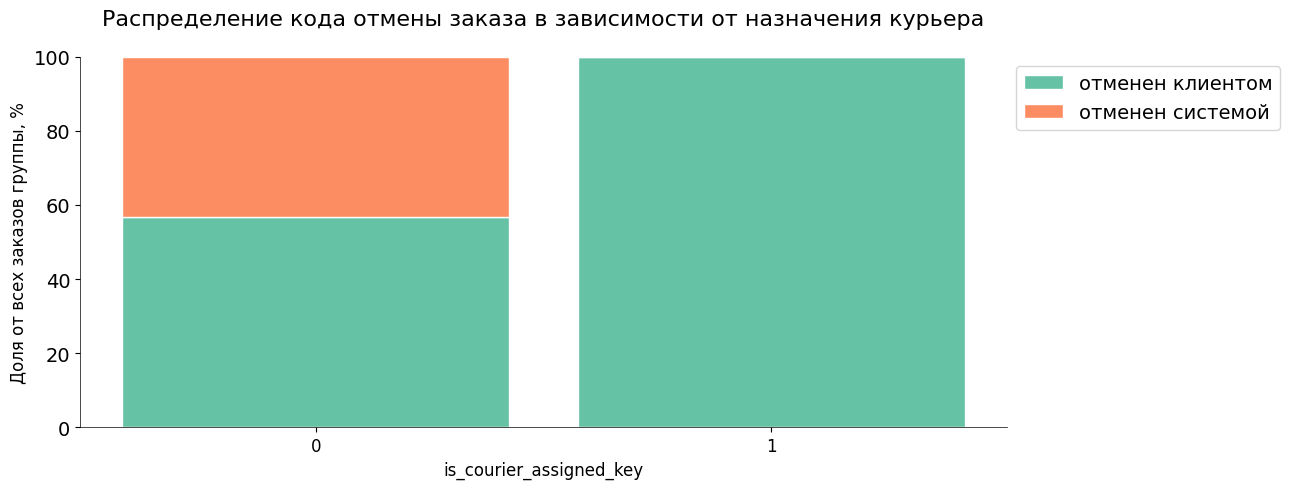

In [185]:
ratio_per_category(orders, 'order_status_flag', 'is_courier_assigned_key', 
                   task_0='отменен клиентом', task_1='отменен системой',
                   title='Распределение кода отмены заказа в зависимости от назначения курьера')

Для заказов, где курьер был назначен, практически всегда отмену производит клиент. Причины отмены заказа до назначения курьера распределены практически поровну: 57% отмен по решению клиента и 43% отмен, вызванных системой.

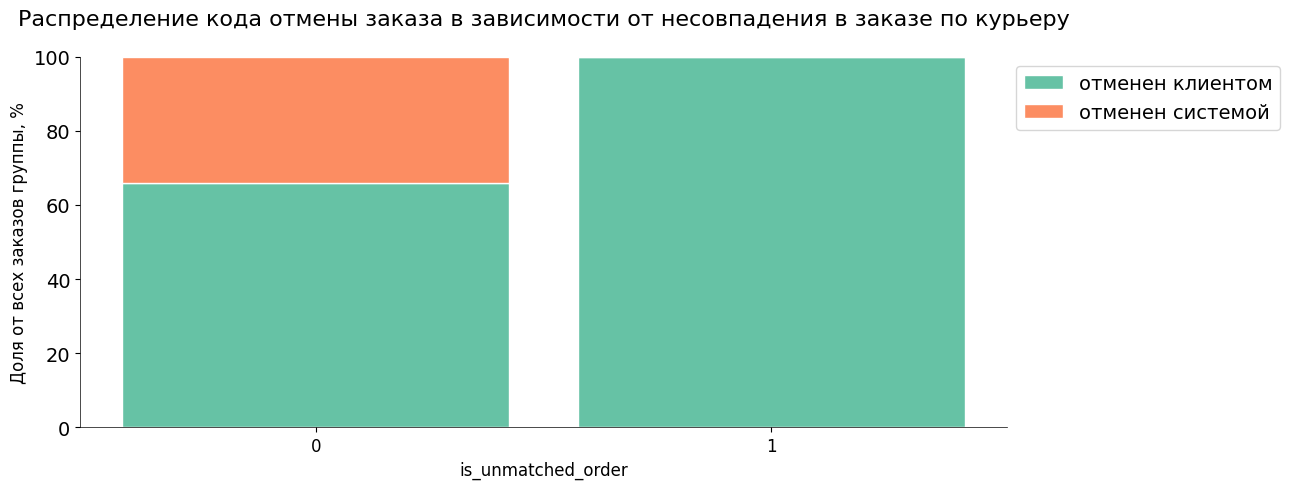

In [186]:
ratio_per_category(orders, 'order_status_flag', 'is_unmatched_order',
                   task_0='отменен клиентом', task_1='отменен системой',
                   title='Распределение кода отмены заказа в зависимости от несовпадения в заказе по курьеру')

В случае с заказами с несовпадениями также видно, что практически все такие заказы отменял клиент самостоятельно.

####  Какова доля заказов с назначенным курьером среди заказов, отмененных системой?

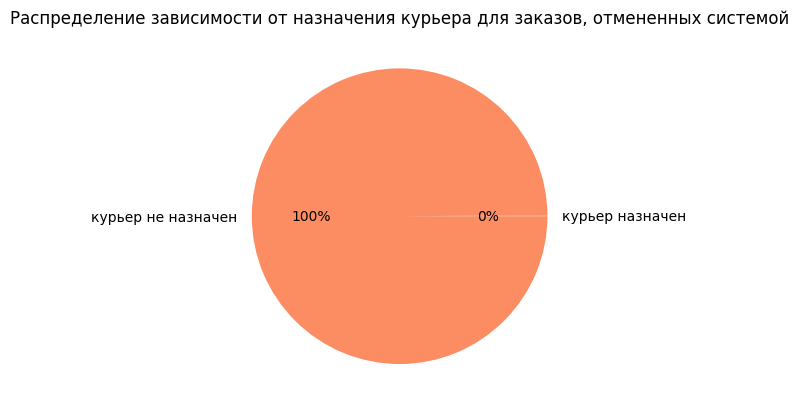

In [187]:
plot_pie(orders[orders['order_status_flag'] == 1], 'is_courier_assigned_key', 
         'Распределение зависимости от назначения курьера для заказов, отмененных системой', 
         labels=['курьер назначен', 'курьер не назначен'])

Практически для всех заказов, отмененных системой, курьер до отмены не был назначен.

#### Изучите среднее времени до отмены с назначенным курьером и без, по часам

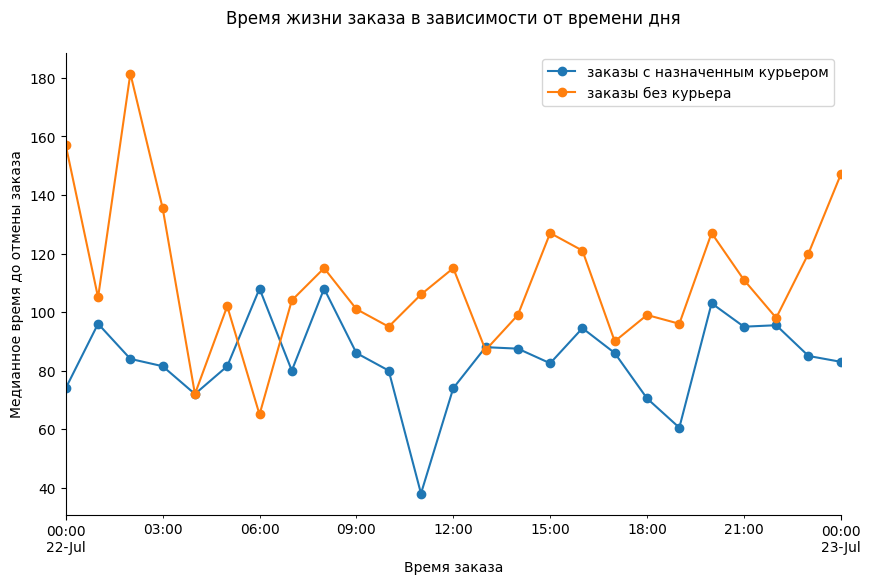

In [188]:
# посмотрим распределение медианного значения времени жизни заказа 
# по часам
fig, ax = plt.subplots(figsize=(10, 6))

waiting_in_time(orders[(orders['cancellations_time_in_seconds'] != -1) & (orders['is_courier_assigned_key'] == 0)], 
                ax, label='заказы с назначенным курьером')
waiting_in_time(orders[(orders['cancellations_time_in_seconds'] != -1) & (orders['is_courier_assigned_key'] == 1)], 
                ax, label='заказы без курьера')

ax.legend(['заказы с назначенным курьером', 'заказы без курьера'])
plt.title('Время жизни заказа в зависимости от времени дня' + '\n', fontsize=12);

По графику можно выделить следующие особенности:

* ночью время ожидания заказа до назначения курьера в среднем выше: видимо, клиенты некоторое время ждут назначения курьера, понимая, что в позднее время найти курьера сложнее обычного
* на графике времени ожидания до отмены заказов с назначенным курьером наблюдается провал около 11 утра: время до отмены значительно ниже обычного.

### Постройте график распределения фейлов по часам - наблюдается ли тендеция, что в какие то часы доля той или иной категории аномально высока?

In [189]:
l = orders['order_hour'].dt.hour.sort_values().unique().tolist()
l.append(0)

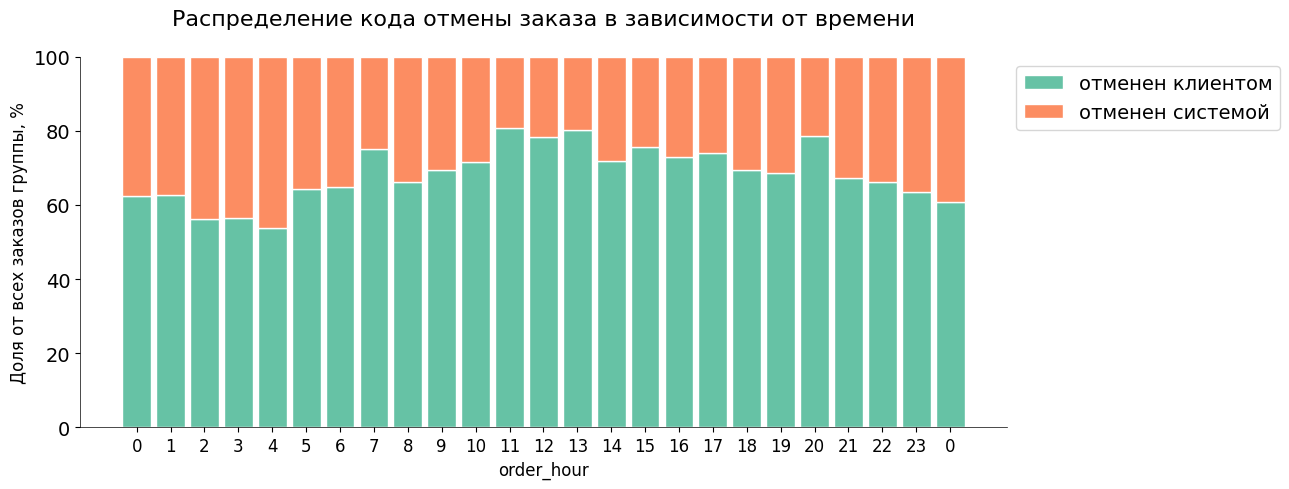

In [190]:
ratio_per_category(orders, 'order_status_flag', 'order_hour', 
                       task_0='отменен клиентом', task_1='отменен системой', l=l,
                       title='Распределение кода отмены заказа в зависимости от времени')

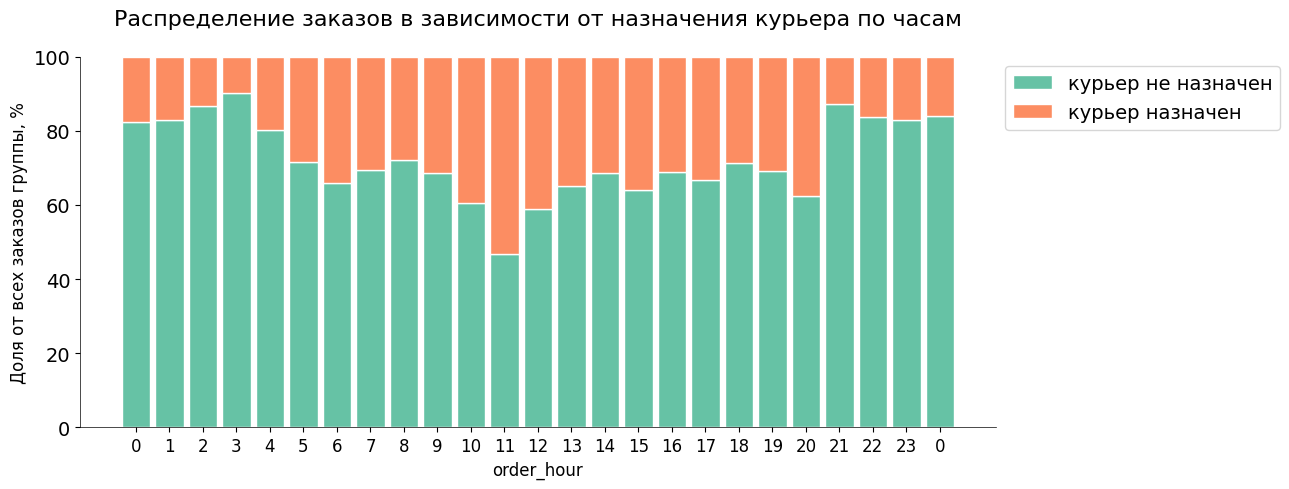

In [191]:
ratio_per_category(orders, 'is_courier_assigned_key', 'order_hour', 
                       task_0='курьер не назначен', task_1='курьер назначен', l=l,
                       title='Распределение заказов в зависимости от назначения курьера по часам')

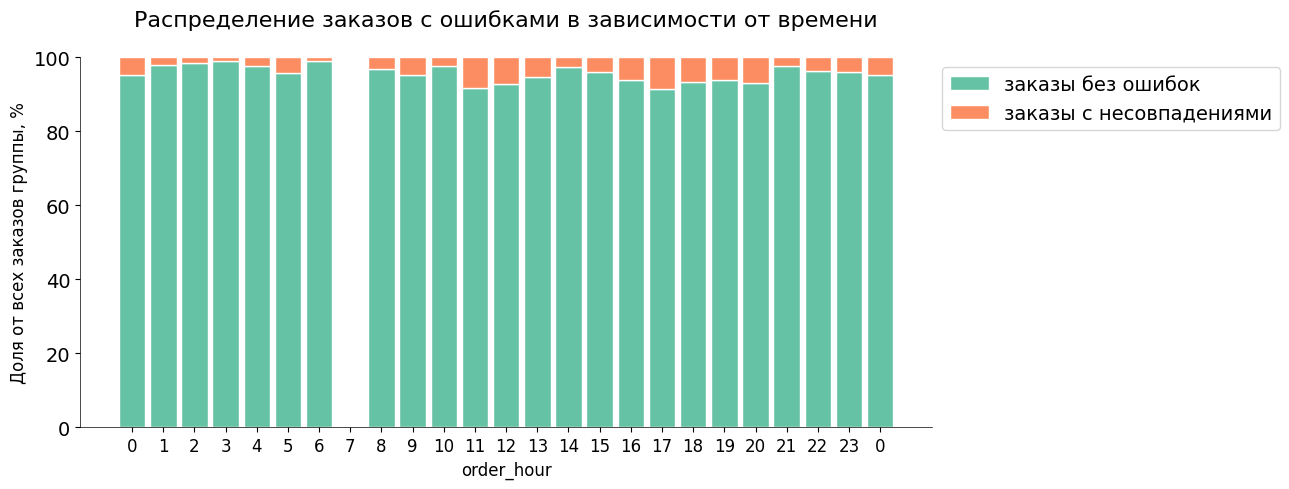

In [192]:
ratio_per_category(orders, 'is_unmatched_order', 'order_hour', 
                       task_0='заказы без ошибок', task_1='заказы с несовпадениями', l=l,
                       title='Распределение заказов с ошибками в зависимости от времени')

Аномалии возникают при рассмотрении распределения заказов с ошибками по часам: в 7 ч приходили только заказы с несовпадениями. Возможно, в этот момент произошла ошибка в системе.

## Выводы

<font size="4"><b>Общие выводы:</b></font>

**Общие наблюдения:**
1. ***Дубликаты в датасетах отсутствуют.***
2. *Пропуски есть только в столбце о времени жизни заказа.*
3. ***Пропуски о времени жизни есть только у тех заказов, которые были отменены системой.*** *Возможно, что для таких заказов есть пропуски во времени жизни по той причине, что заказ (например, из-за плохого интернет-соединения, ошибки оплаты и т.д.) отменяется практически сразу после своего формирования.*
4. *Пропуски во времени жизни были заменены специальным значением **"-1"**.*
5. *Обнаружены* ***аномально высокие значения*** *в столбце о* ***времени жизни заказа:*** *некоторые заказы отменяются спустя час ожидания.*
6. *Самые долгие времена жизни заказов выпадают в полночь, а также в 5, 7 утра и 13 дня. Чтобы говорить о некоторой периодичности отмены заказа именно в эти часы, необходимо располагать данными за несколько недель. В данном случае ничего дополнительно сказать нельзя.*
7. *Для дальнейшнего исследования* ***были оставлены только те заказы, чьё время ожидания укладывается в 10 мин.*** *Доля потерянных данных составила **менее 3%**.*
8. *Были заменены типы данных.*
9. *Был добавлен **столбец с количеством минут ожидания заказа до его отмены**. Значение получено путём округления времени вверх (53 секунды считаются 2-мя минутами).*
10. *В датасете `offers` обнаружены записи о заказах, информация о которых отсутствует в `orders`. Такие записи были удалены.*
11. *Обнаружены **заказы с несовпадением информации о курьере в `orders` и `offers`:** в первом датасете отмечено, что курьер для заказа назначен, в то время как в `offers` нет информации о предложениях по этому заказу курьерам. Этому может быть 2 причины: либо `offers` не обладает полной информацией о заказах в течение исследуемого дня, либо есть ошибка в системе. Исходя из наблюдаемых зависимостей, вторая причина может быть верной:* ***возможно, что программа считала, что курьер назначен, в то время как на самом деле никаких предложений курьерам не отправлялось, клиент ожидал решения своей проблемы, недожидался, отменял заказ.***

**По вопросам заказчика:**

12. ***Большая часть заказов (67%) отменена клиентом.*** ***Треть заказов отменена системой.*** *Кроме того, для этой трети заказов отсутствует информация о времени жизни заказа, возможно, что эти* ***заказы были отменены в первую секунду формирования.***
13. ***Большинство заказов в датасете (76%) были отменены ещё до назначения курьера.**
14. ***У 4% заказов присутствуют несовпадения*** *с датасетом `offers` касательно информации о назначении курьера. Как было отмечено в пункте 2.6, эти* ***несовпадения могут быть вызваны ошибкой в программе:*** *для заказов с несовпадениями наблюдается повышенное время ожидания до отмены и увличенная доля заказов, отмененных клиентами самостоятельно. Возможно, что программа "считала", что курьер назначен, в то время как на самом деле никаких предложений курьерам не отправлялось, клиент ожидал решения своей проблемы, не дожидался, отменял заказ.*
15. *По графику можно отметить, что в этот день самые активные на заказы часы были утром (8-9 ч утра) и вечером (21-24 ч). Меньше всего заказов ранним утром (4-6 утра), а также около 11ч.*
16. *На графике в целом не наблюдаются сильно выделяющиеся часы. В среднем меньше всего время ожидания клиентом до отмены было в 4ч утра, дольше всего ждали в 8 утра.*
17. ***Для заказов, где курьер был назначен, практически всегда отмену производит клиент.*** *Причины отмены заказа до назначения курьера распределены практически поровну: 57% отмен по решению клиента и 43% отмен, вызванных системой.*
18. *В случае с* ***заказами с несовпадениями*** *также видно, что практически* ***все такие заказы отменял клиент самостоятельно.***
20. *Практически для всех заказов, отмененных системой, курьер до отмены не был назначен.*
21. *Аномалии возникают при рассмотрении распределения заказов с ошибками по часам:* ***в 7 ч приходили только заказы с несовпадениями.*** *Возможно, в этот момент произошла ошибка в системе.*

<font size="4"><b>Рекомендации:</b></font>

***1. Проверить, не было ли сбоев в работе системы в промежутке 6-7 утра.***

***2. Проверить работу системы для заказов, для которых были выявлены несоответствия между датасетами: потенциально в этих заказах у системы возникает ошибка, которая впоследствии заставляет клиентов отменить заказ.***